In [35]:
import pandas as pd
import numpy as np

import tensorflow as tf
import spacy as sp
import regex as re
    
import tensorflow as tf
from tensorflow.keras.models  import Model
from tensorflow.keras.layers import *
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv("./train.csv")

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
SYMBOL_FILTER = re.compile("[!@#%:;,\.?\'\"]")
CLEAN_UP = re.compile("[^a-z]")
WHITESPCAE_FILTER = re.compile("  *")

def extract_words(x):
    x = " ".join(SYMBOL_FILTER.sub("",x.lower()).split())
    x = " ".join(CLEAN_UP.sub(" ",x).split())
    x = " ".join(WHITESPCAE_FILTER.sub(" ",x).split())
    return x

df['comment_text_clean'] = df.comment_text.apply(extract_words)

In [5]:
### Counting NUmber Of Words
from collections import Counter

In [6]:
words = Counter()

for line in df.comment_text_clean:
    for word in line.split():
        words[word] += 1
        

In [7]:
len(words.keys())

197406

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
cv = CountVectorizer()

In [13]:
cv.fit(df.comment_text_clean.values.reshape(-1))

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [14]:
target = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
labels = df[target].copy()

In [15]:
labels.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [16]:
df = df.drop(columns=target)

In [17]:
temp = df.pop("id")

In [18]:
del temp

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score

In [20]:
X,x,Y,y = train_test_split(df.comment_text_clean.values,labels)

In [21]:
INPUT_SHAPE = cv.transform([X[0]]).toarray().shape[1]

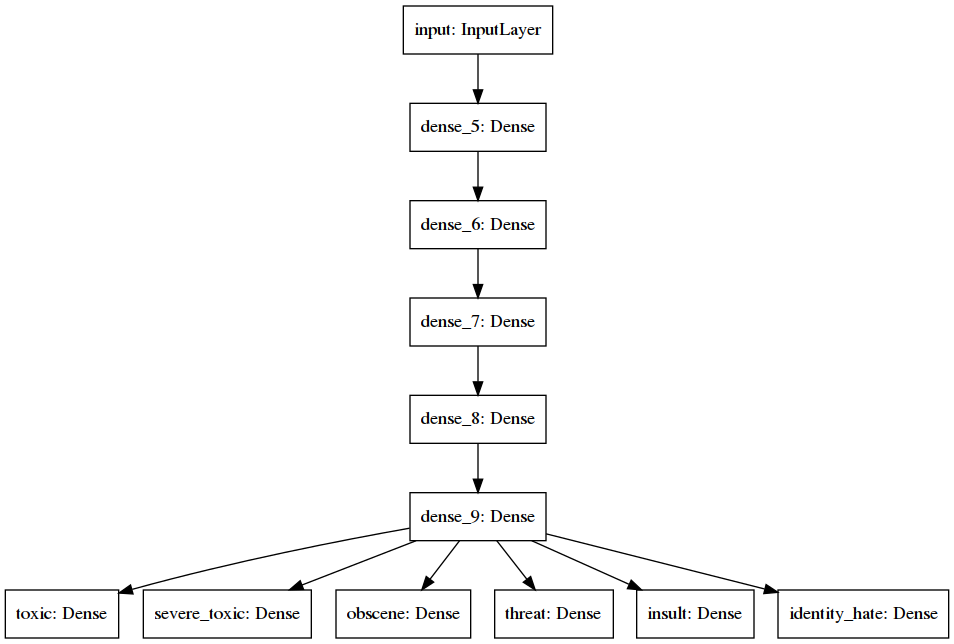

In [23]:
inputs = Input(shape=(INPUT_SHAPE,),name="input")

model = Dense(32,activation="relu",input_shape=(INPUT_SHAPE,))(inputs)
model = Dense(32,activation="relu")(model)
model = Dense(64,activation="relu")(model)
model = Dense(128,activation="relu")(model)
model = Dense(1024,activation="relu")(model)

toxic = Dense(2,activation="softmax",name="toxic")(model)
severe_toxic = Dense(2,activation="softmax",name="severe_toxic")(model)
obscene = Dense(2,activation="softmax",name="obscene")(model)
threat = Dense(2,activation="softmax",name="threat")(model)
insult = Dense(2,activation="softmax",name="insult")(model)
identity_threat = Dense(2,activation="softmax",name="identity_hate")(model)

model = Model(inputs=[inputs],outputs=[toxic,severe_toxic,obscene,threat,insult,identity_threat])

tf.keras.utils.plot_model(model)

In [40]:
def input_gen(x,y,epochs=5,bar=False):
    for epoch in range(epochs):
        iter_ = tqdm(range(x.shape[0])) if bar else range(x.shape[0]) 
        for i in iter_:
            targets = {
                            j:np.array([0,1]).reshape(1,-1)
                                if y[j].iloc[i] == 0 
                                else np.array([1,0]).reshape(1,-1)
                            for j in target 
                    }
            yield (
                    {
                        "input":cv.transform([x[i]]).toarray()[0].reshape(1,-1)
                    },
                    targets
                )

i = input_gen(X,Y)            
next(i)

({'input': array([[0, 0, 0, ..., 0, 0, 0]])},
 {'toxic': array([[0, 1]]),
  'severe_toxic': array([[0, 1]]),
  'obscene': array([[0, 1]]),
  'threat': array([[0, 1]]),
  'insult': array([[0, 1]]),
  'identity_hate': array([[0, 1]])})

In [25]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])

In [27]:
EPOCHS = 1
history = model.fit_generator(input_gen(X,Y,epochs=EPOCHS),steps_per_epoch=X.shape[0],epochs=EPOCHS)

119678/119678 [==============================] - 990s 8ms/step - loss: 0.5530 - toxic_loss: 0.1736 - severe_toxic_loss: 0.0774 - obscene_loss: 0.1024 - threat_loss: 0.0531 - insult_loss: 0.1020 - identity_hate_loss: 0.0445 - toxic_acc: 0.9507 - severe_toxic_acc: 0.9898 - obscene_acc: 0.9735 - threat_acc: 0.9972 - insult_acc: 0.9696 - identity_hate_acc: 0.9916


In [42]:
acc = model.evaluate_generator(input_gen(x,y,epochs=1,bar=True),steps=x.shape[0])

In [43]:
acc

[0.7479547372204729,
 0.28287563,
 0.04922207,
 0.16589183,
 0.028371392,
 0.16253446,
 0.059077106,
 0.90369236,
 0.9904244,
 0.94633144,
 0.9965658,
 0.9497155,
 0.98987293]